In [1]:
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, make_scorer
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Input, Activation, Dense
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy

from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns


# Reading Data

In [2]:
data_path = './data/Fraud_Data.csv'
fraud_data = pd.read_csv(data_path)

In [3]:
fraud_data.head()

Unnamed: 0  user_id      signup_time    purchase_time  purchase_value  \
0      149671   285108   7/15/2015 4:36  9/10/2015 14:17              31   
1       15611   131009  1/24/2015 12:29   4/13/2015 4:53              31   
2       73178   328855   3/11/2015 0:54   4/5/2015 12:23              16   
3       84546   229053   1/7/2015 13:19   1/9/2015 10:12              29   
4       35978   108439   2/8/2015 21:11   4/9/2015 14:26              26   

       device_id  source  browser sex  age    ip_address  class  
0  HZAKVUFTDOSFD  Direct   Chrome   M   49  2.818400e+09      0  
1  XGQAJSOUJIZCC     SEO       IE   F   21  3.251268e+09      0  
2  VCCTAYDCWKZIY  Direct       IE   M   26  2.727760e+09      0  
3  MFFIHYNXCJLEY     SEO   Chrome   M   34  2.083420e+09      0  
4  WMSXWGVPNIFBM     Ads  FireFox   M   33  3.207913e+09      0

In [4]:
# drop irrelevant column
fraud_data = fraud_data.drop(['Unnamed: 0'], axis=1)

In [5]:
# data size
fraud_data.shape

(120000, 11)

In [6]:
# column types
fraud_data.dtypes

user_id             int64
signup_time        object
purchase_time      object
purchase_value      int64
device_id          object
source             object
browser            object
sex                object
age                 int64
ip_address        float64
class               int64
dtype: object

# Data Exploration

Apart from the standard checks above, I am using the YData Profiling to get a holistic view of the data through reports, statistics and visualizations.

In [48]:
# Using YData Profiling to get a first impression of the data
ProfileReport(fraud_data, title="Profiling Report")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## investigate `purchase_value` column 
Here I want to understand better what are the financial impact associated with false positives (wrongly flagging valid transactions as fraud) and false negatives (failing to detect fraud).

In [7]:
# sum of purchase value of fraudulent vs. non-fraudulent cases.
purchase_sum_per_class = fraud_data.groupby('class')['purchase_value'].sum()
print(purchase_sum_per_class)

class
0    4008227
1     417550
Name: purchase_value, dtype: int64


The total loss due to failing to detect fraud is `417'550 $`

In [8]:
purchase_count_per_class = fraud_data.groupby('class')['purchase_value'].count()

print(purchase_count_per_class)

class
0    108735
1     11265
Name: purchase_value, dtype: int64


In [9]:
8 * purchase_count_per_class[0]

869880

### Contextualizing the Costs:
* Missing fraud cases leads to financial loss of `$417,550` due to fraud, which the company cannot recover.
* Flagging legitimate transactions as fraud costs the company `$869,880`, in addition to potential customer dissatisfaction.

While increasing recall by 10% would allow us to catch more fraudulent transactions, it comes at the cost of decreasing precision by 20%. This means the company will incur an additional cost of `$173,976 (0.2 * $869,880)` due to wrongly flagged valid transactions. Additionally, there are longer-term consequences such as customer dissatisfaction, which is harder to quantify but can lead to churn and reputational damage. Given that the financial loss from fraud `($417,550)` is significantly lower than the cost of wrongly flagged valid transactions `($869,880)`, it may be more prudent to prioritize precision to maintain customer satisfaction and reduce unnecessary financial loss.

However, if the loss from undetected fraud outweighs the inconvenience of false positives, an `F1-score` might be a better metric, as it seeks to balance the trade-offs between precision and recall, ensuring that both fraud detection and customer satisfaction are optimized.


## Main takeaways from the report
* Data has no missing values, nor any duplicates
* The type of `signup_time` and `purchase_time` columns needs to be converted to proper datetime type.
* The distribution of `signup_time` and `purchase_time` shows a spike in the beginning of the year, which requires further checks
* While `user_id` column is 100% distinct, `device_id` and `ip_address` columns are not, which raises suspicion
* Looking at the distribution of the `purchase_value` column, an F1-score might be a better metric for the model, as it seeks to balance the trade-offs between precision and recall
* `class` column is highly imbalanced (108'735 non-fraud vs. 11'265 fraud) and needs to be addressed in the modeling stage

In [10]:
# double check
fraud_data.isna().sum()

user_id           0
signup_time       0
purchase_time     0
purchase_value    0
device_id         0
source            0
browser           0
sex               0
age               0
ip_address        0
class             0
dtype: int64

In [11]:
fraud_data['class'].value_counts()

class
0    108735
1     11265
Name: count, dtype: int64

# Feature Engineering

The model requires numeric features, so in the first step the `sex` column is mapped to 0 and 1 values 

In [12]:
# covert 'sex' column to 0 or 1 in order to be used in the mdoel 
fraud_data['sex'] = (fraud_data.sex == 'M').astype(int)

### time difference between signup and purchase
I observed that for some fraudulent case, the `signup_time` and the `purchase_time` columns were the same values. Therefore, I created a new column called `time_to_purchase` which calculates the difference bwtween those two columns in hours. The result is then rounded up for readability.

In [13]:
# Converting signup_time and purchase_time columns to datetime format
fraud_data['signup_time'] = pd.to_datetime(fraud_data['signup_time'])
fraud_data['purchase_time'] = pd.to_datetime(fraud_data['purchase_time'])

# Calculating the time difference between signup and purchase in hours
fraud_data['time_to_purchase'] = (fraud_data['purchase_time'] - fraud_data['signup_time']).dt.total_seconds() / 3600  # hours
fraud_data['time_to_purchase'] = fraud_data['time_to_purchase'].round(2)

### outlier detection
Next, I wanted to examine the relationship between purchase dates and fraudulent activity. Specifically, I would like to visualize this with a stacked histogram, where the x-axis represents purchase dates and the y-axis shows the number of transactions, stacked by fraud (fraudulent vs. non-fraudulent) status.

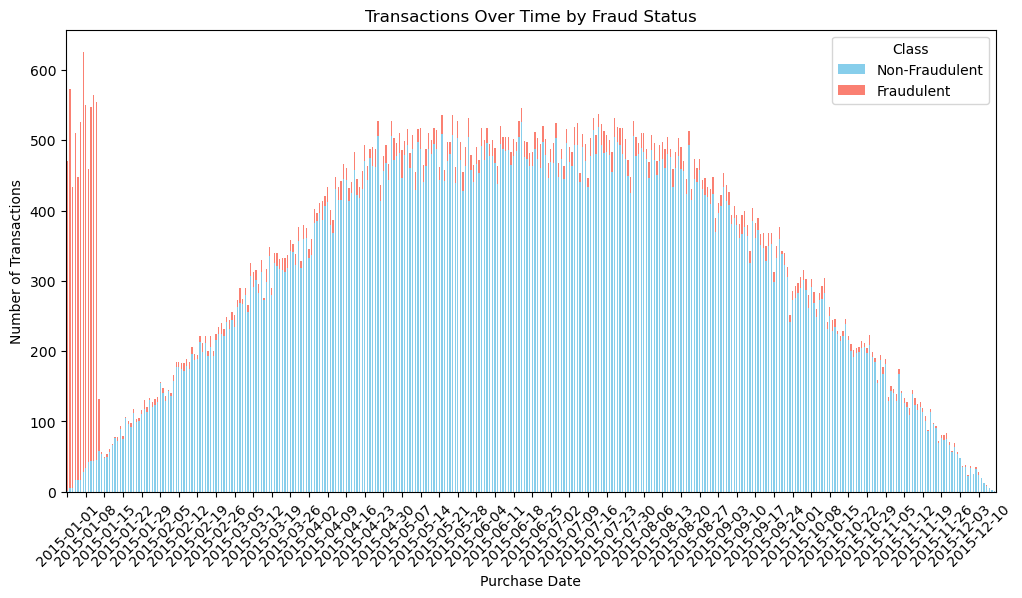

In [14]:
# Extract the date part for grouping
fraud_data['purchase_date'] = fraud_data['purchase_time'].dt.date

# Group by date and class to get transaction counts
transactions_by_date = fraud_data.groupby(['purchase_date', 'class']).size().unstack(fill_value=0)

# Plotting the stacked histogram
transactions_by_date.plot(kind='bar', stacked=True, figsize=(12, 6), color=['skyblue', 'salmon'])
plt.title("Transactions Over Time by Fraud Status")
plt.xlabel("Purchase Date")
plt.ylabel("Number of Transactions")
plt.legend(["Non-Fraudulent", "Fraudulent"], title="Class")
plt.xticks(ticks=range(0, len(transactions_by_date.index), 7), labels=transactions_by_date.index[::7], rotation=45)  # Show every 7th date
# plt.tight_layout()
plt.show()


This graph reveals a significant concentration of fraudulent cases at the beginning of the year, which appears highly suspicious. 
However, without data from the following year for comparison to determine if this is a recurring pattern, I am employing the following approach for my analysis:

* Develop a Time-based Feature: Instead of removing this portion of data, add a feature to capture this time-of-year effect (e.g., a "seasonal" feature), which may help the model capture any true seasonal patterns if they exist.


In [15]:
# Add `in_fraud_spike_period` as a binary feature (e.g., high fraud risk Jan 1 - Jan 13)
start_date = pd.Timestamp('2015-01-01')
end_date = pd.Timestamp('2015-01-13')
fraud_data['in_fraud_spike_period'] = fraud_data['purchase_time'].apply(lambda x: 1 if x >= start_date and x <= end_date else 0)

### build feature for shared device id and IP address
As it was discovered in the profiling report, the `device_id` field is not distinct. Multiple users using the same device could be a sign of suspicious activity, like shared or compromised devices. Same applies to the IP address, the more frequent the IP address is shared, the higher chance of suspicious activity.

Therefore, I create the following features:
* Count number of users for each device
* Count number of IP addresses shared

In [16]:
# Count the number of unique users for each device
device_user_count = fraud_data.groupby('device_id')['user_id'].nunique().reset_index()
device_user_count.columns = ['device_id', 'user_count_per_device']

# Merge this count back into the original dataset
fraud_data = fraud_data.merge(device_user_count, on='device_id', how='left')

# add column for number of shared IPs
fraud_data['n_ip_shared'] = fraud_data.ip_address.map(fraud_data.ip_address.value_counts())

### build feature for IP to country mapping
This feature focuses on deriving user's location using the IP address. The idea is to find out whether there are certain countries where the majority of the fraud cases are happening and based on that, assign a risk category to each country (low, mid, high).

For this, the provided excel file for IP range to country will be used, i.e. for each IP address in the fraud dataset, the relevant in the mapping dataset will be found and the country is assigned. 
* Due to the size of the data, using a `for loop` was very slow. Therefore, a `vectorized lookup` using numpy search was used, which speeds up the calculations significantly.
* I have written a test for this function under `tests/test_feature_engineering.py`, as it is particularly important to detect the cases well.

In [17]:
ip_mapping_path = './data/IpAddress_to_Country.xlsx'

# Step 1: Read the IP-to-country mapping from the Excel file
ip_mapping_df = pd.read_excel(ip_mapping_path)
ip_mapping_df['lower_bound_ip_address'] = ip_mapping_df['lower_bound_ip_address'].astype(int)
ip_mapping_df['upper_bound_ip_address'] = ip_mapping_df['upper_bound_ip_address'].astype(int)

# Step 2: Sort the IP-to-country mapping by the lower_bound_ip_address
ip_mapping_df.sort_values(by='lower_bound_ip_address', inplace=True)

# Step 3: Prepare arrays for efficient lookup
lower_bound_ips = ip_mapping_df['lower_bound_ip_address'].values
upper_bound_ips = ip_mapping_df['upper_bound_ip_address'].values
countries = ip_mapping_df['country'].values

# Step 5-a: Vectorized lookup using binary search
def find_country(ip, lower_bound_ips, upper_bound_ips):
    # Use numpy search to quickly find the index of the range that contains the IP address
    idx = np.searchsorted(upper_bound_ips, ip, side='left')
    if 0 <= idx < len(lower_bound_ips) and lower_bound_ips[idx] <= ip <= upper_bound_ips[idx]:
        return countries[idx]
    return 'Unknown'

# Step 5-b: Apply the function to the dataset
fraud_data['country'] = fraud_data['ip_address'].apply(find_country, args=(lower_bound_ips, upper_bound_ips))

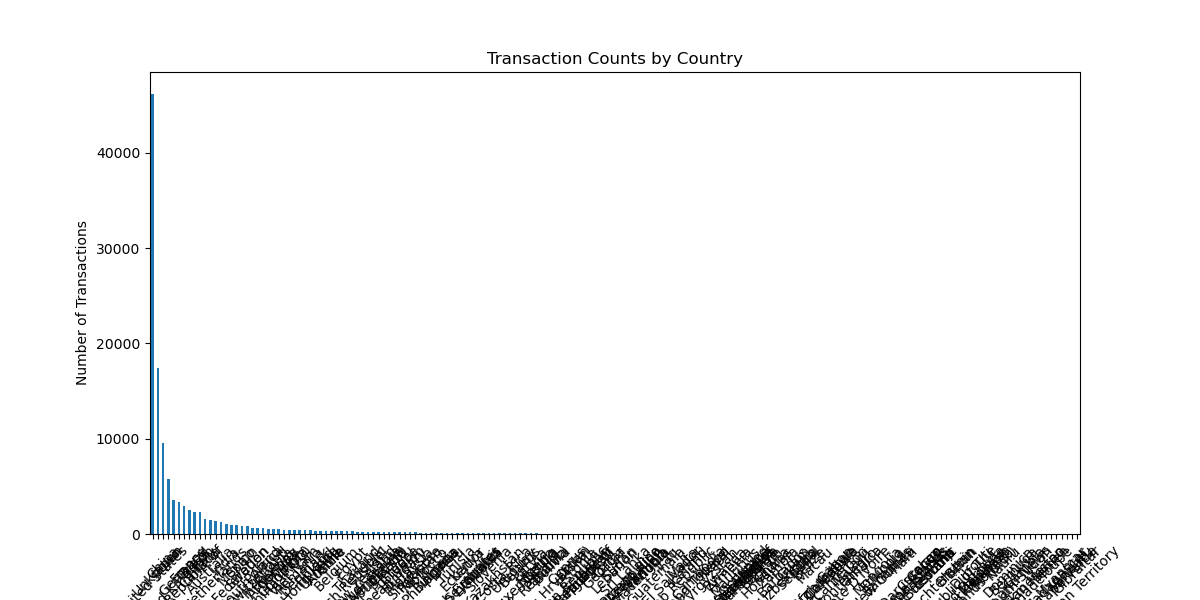

In [18]:
%matplotlib widget
# visualize the country column to see the distribution of data
fraud_data['country'].value_counts().plot(kind='bar', figsize=(12, 6))
plt.xlabel('Country')
plt.ylabel('Number of Transactions')
plt.title('Transaction Counts by Country')
plt.xticks(rotation=45)
plt.show()

In [19]:
fraud_data['country'].value_counts()

country
United States     46184
Unknown           17418
China              9532
Japan              5735
United Kingdom     3580
                  ...  
Madagascar            1
Myanmar               1
Cape Verde            1
Vanuatu               1
Gibraltar             1
Name: count, Length: 177, dtype: int64

As shown in the plot, the distribution is highly skewed, with only a few countries exhibiting a high number of fraud cases, while many have very few, and the majority report just one. In the next step, risk categories will be assigned to the countries. To do this, I use quantile ranges from the data to define thresholds. These thresholds are chosen based on patterns observed in the data to distinguish between high-risk, mid-risk, and low-risk countries. These values can either be configured by the user or potentially treated as hyperparameters during the modeling stage for optimization.

In [20]:
# Calculate the number of fraudulent cases per country:
fraud_count_by_country = fraud_data.groupby('country')['class'].sum()

# Define thresholds for risk categories: 
high_risk_threshold = fraud_count_by_country.quantile(0.9)  # 90th percentile
low_risk_threshold = fraud_count_by_country.quantile(0.7)   # 70th percentile

# Function to assign risk categories
def categorize_risk(fraud_count):
    if fraud_count >= high_risk_threshold:
        return 'High-Risk'
    elif fraud_count <= low_risk_threshold:
        return 'Low-Risk'
    else:
        return 'Mid-Risk'

fraud_count_by_country = fraud_count_by_country.apply(categorize_risk)
fraud_data['country_risk_category'] = fraud_data['country'].map(fraud_count_by_country)

I tried to see if there is a correlation between the countries and the period in the beginning of the year and develop a potential feature based on that. 

However, this didn't show any specific pattern in the data and the majority stays with US, Unknown and China.

/var/folders/4c/9_dg2k1d6c98sv5b2hr5dqhr0000gn/T/ipykernel_45596/369227549.py:21: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


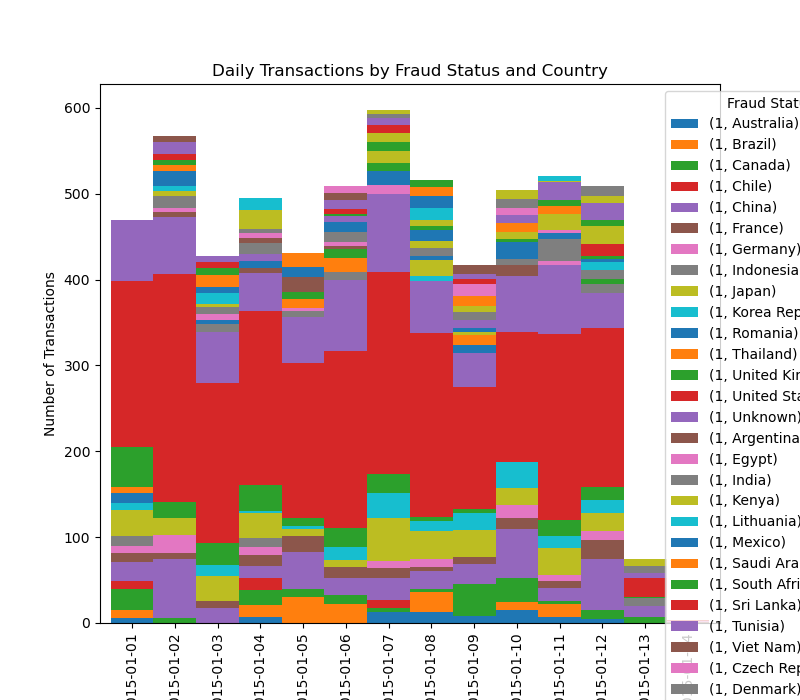

In [21]:
filtered_data = fraud_data[(fraud_data['purchase_time'] >= '2015-01-01') 
                & (fraud_data['purchase_time'] <= '2015-01-15')
                & (fraud_data['class'] == 1)]

# Group by date, class (fraud/non-fraud), and country, then count
daily_counts = (
    filtered_data.groupby([filtered_data['purchase_time'].dt.date, 'class', 'country'])
    .size()
    .unstack(level=[1, 2], fill_value=0)
)

# Plot stacked histogram
daily_counts.plot(kind='bar', stacked=True, figsize=(8, 7), width=1)

# Formatting the plot
plt.xlabel('Date')
plt.ylabel('Number of Transactions')
plt.title('Daily Transactions by Fraud Status and Country')
# plt.xticks(ticks=range(0, len(daily_counts.index), 7), labels=daily_counts.index[::7], rotation=45)  # Show every 7th date
plt.legend(title='Fraud Status and Country', bbox_to_anchor=(0.9, 1), loc='upper left')
plt.tight_layout()
plt.show()

### feature for categorical variables: 
Fraudsters may use specific channels or browsers. Patterns in these features could help identify abnormal behaviors. Since there are different categories in the `source` and `browser` columns, a One-Hot Encoding approach is used to converts categorical variables into a series of binary (0 or 1) columns. The same applies to the `country_risk_category` column.

In [22]:
# apply one-hot-encoding to the columns
fraud_data = pd.get_dummies(fraud_data, columns=['source', 'browser', 'country_risk_category'], dtype='int')

### choosing relevant columns as input features
In this stage, only the columns that will be used in the modeling are selected. The `age` and `purchase_value` columns will be used as is and later will be scaled depending on the algorithm used.

In [23]:
features_sel = ['purchase_value', 'sex', 'age', 'in_fraud_spike_period',
       'time_to_purchase', 'user_count_per_device', 'n_ip_shared',
       'source_Ads', 'source_Direct', 'source_SEO', 'browser_Chrome',
       'browser_FireFox', 'browser_IE', 'browser_Opera', 'browser_Safari',
       'country_risk_category_High-Risk', 'country_risk_category_Low-Risk',
       'country_risk_category_Mid-Risk', 'class']
fraud_data = fraud_data.loc[:, features_sel]

### Correlation analysis
In order to understand the relationships between variables, I use correlation analysis to identify highly correlated features which can introduce redundancy.

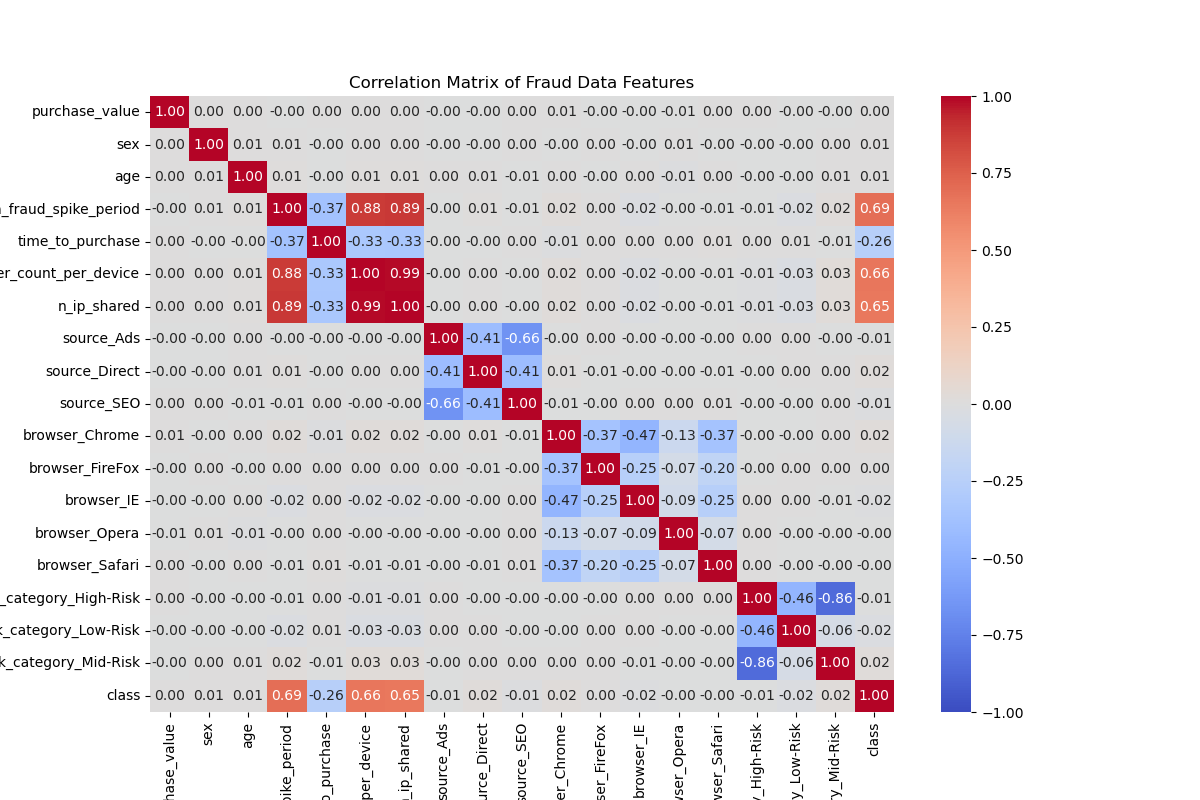

In [24]:
# Calculate the correlation matrix
correlation_matrix = fraud_data.corr()

# Display the correlation matrix as a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Matrix of Fraud Data Features")
plt.show()

The correlation analysis shows that the categorical features are correlated, which is expected. There is also a very high correlation (99%) between user_count_per_device and n_ip_shared, likely because multiple devices are using the same IP addresses. Since these variables offer similar predictive power, I will remove n_ip_shared from the analysis to avoid redundancy.

In [25]:
fraud_data = fraud_data.drop(['n_ip_shared'], axis=1)

## Scaling features
Scales features to a fixed range (0 - 1) before feeding into the model. This is useful for continuous numeric features with a wide range of values or when the algorithm is sensetive to the feature scale (Logistic Regression, Neural Network, KNN, etc.)

In [26]:
# Initialize the scaler
scaler = MinMaxScaler()

# List of features to scale
features_to_scale = ['time_to_purchase', 'purchase_value', 'age', 'user_count_per_device']
# features_to_scale = ['time_to_purchase', 'user_count_per_device', 'n_ip_shared']

# Fit and transform the scaler on the selected features
fraud_data[features_to_scale] = scaler.fit_transform(fraud_data[features_to_scale])

## Split Data

In [27]:
y = fraud_data['class']
X = fraud_data.drop(['class'], axis=1)

# Step 1: Split into train and holdout test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train.shape:", X_train.shape)
print("y_train.shape:", y_train.shape)
print("X_test.shape:", X_test.shape)
print("y_test.shape:", y_test.shape)


X_train.shape: (96000, 17)
y_train.shape: (96000,)
X_test.shape: (24000, 17)
y_test.shape: (24000,)


# Modeling

In the modeling part, I would start with rather simpler approach (Logistic Regression) and see how it performs. Then I will try to optimize using a combination of methods:
* Resampling techniques: because of the imbalnce in the `class` with the fraud cases only ~10% of non-fraud cases, oversampling the minority class (e.g., using SMOTE) or undersampling the majority class can help balance the training data.
* Optimizing model weights refer to the relative importance given to each class when calculating the loss function during training.
    * Automatic "balanced" setting: With class_weight='balanced', scikit-learn calculates weights based on class frequencies (e.g., making the rare class weight higher).
    * Adjusting class weight by assigning higher weights to minority classes. Class Weight `{0: 1, 1: 2}`: The model will "pay twice as much attention" to errors on class 1 (fraud cases, for example) compared to class 0 (non-fraud)
* Using more advances models like Random Forest, XGBoost and Neural Networks
    * try combination of advanced models with resampled dataset

In [28]:
def fit_evaluate_model(model, X_train, y_train, X_test, y_test):
    # Funciton to fit the model, make prediction on the test set and print out evaluation metrics
    # Fit the model on the entire training set
    model.fit(X_train, y_train)

    # Predict on the holdout test set
    y_pred = model.predict(X_test)
    
    # Evaluate the model on the holdout test set
    print(classification_report(y_test, y_pred))  # Show precision, recall, F1-score

def cross_val(model, X, y):
    # run cross-validation on the entire dataset
    scoring = {
        'precision': make_scorer(precision_score),
        'recall': make_scorer(recall_score),
        'f1_score': make_scorer(f1_score)
    }
    print(cross_validate(model, X, y, scoring=scoring, cv=5))
    

## Baseline logistic regression

In [29]:
# Initialize the logistic regression model
logistic = LogisticRegression()

fit_evaluate_model(logistic, X_train, y_train, X_test, y_test)
cross_val(logistic, X, y)

              precision    recall  f1-score   support

           0       0.95      1.00      0.97     21768
           1       0.92      0.53      0.67      2232

    accuracy                           0.95     24000
   macro avg       0.94      0.76      0.82     24000
weighted avg       0.95      0.95      0.95     24000

{'fit_time': array([0.05271912, 0.16002131, 0.05967832, 0.07901692, 0.05524302]), 'score_time': array([0.01313186, 0.01658297, 0.01391482, 0.01373911, 0.01302409]), 'test_precision': array([0.92248062, 0.91422122, 0.91957511, 0.90860625, 0.92432432]), 'test_recall': array([0.52818464, 0.53928096, 0.5379494 , 0.5295162 , 0.53129161]), 'test_f1_score': array([0.67174711, 0.67839196, 0.67880146, 0.66909703, 0.67474634])}


In [30]:
logistic = LogisticRegression(class_weight='balanced')

fit_evaluate_model(logistic, X_train, y_train, X_test, y_test)
cross_val(logistic, X, y)

              precision    recall  f1-score   support

           0       0.96      0.98      0.97     21768
           1       0.73      0.60      0.66      2232

    accuracy                           0.94     24000
   macro avg       0.85      0.79      0.81     24000
weighted avg       0.94      0.94      0.94     24000

{'fit_time': array([0.08202195, 0.09118676, 0.08705306, 0.08091784, 0.08723307]), 'score_time': array([0.01353717, 0.01492095, 0.01444006, 0.01271725, 0.01269507]), 'test_precision': array([0.67278879, 0.66417562, 0.7790218 , 0.59663521, 0.69527679]), 'test_recall': array([0.61784288, 0.63115846, 0.58677319, 0.64536174, 0.60763427]), 'test_f1_score': array([0.64414623, 0.64724624, 0.66936709, 0.62004264, 0.64850782])}


First quick observation is that adjusting the class weigh using `class_weight='balanced'` indeed improves the recall (detecting fraud cases), however the precision drastically decreases (by about 20%).

## implementing grid search to get most optimal class weights

In [31]:
# Define the parameter grid for class weights
param_grid = {'class_weight': [{0: 1, 1: w} for w in range(1, 10)]}
grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='f1')

grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

print("Best class weight:", best_model.class_weight)


Best class weight: {0: 1, 1: 1}


The results show that the model doesn't necessary find any difference between the class weights. Therefore, the model based on optimal values from grid search will provide the same results as original logistic regression.

In [32]:
# Predict on the holdout test set
y_pred = grid_search.predict(X_test)

# Generate class probabilities for the holdout test set
probs = grid_search.predict_proba(X_test)

# Evaluate the model on the holdout test set
print(classification_report(y_test, y_pred))  # Show precision, recall, F1-score

              precision    recall  f1-score   support

           0       0.95      1.00      0.97     21768
           1       0.92      0.53      0.67      2232

    accuracy                           0.95     24000
   macro avg       0.94      0.76      0.82     24000
weighted avg       0.95      0.95      0.95     24000



## Apply Over-sampling: SMOTE
SMOTE (Synthetic Minority Over-sampling Technique) is a technique used to address class imbalance. It works by creating synthetic samples of the minority class rather than simply duplicating existing ones. This is done by selecting a data point from the minority class and generating new instances by interpolating between that point and its nearest neighbors. SMOTE helps improve model performance by making the minority class more represented in the training data, reducing bias toward the majority class.

In [33]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
print(X_resampled.shape)
print(y_resampled.shape)

(173934, 17)
(173934,)


In [34]:
logistic = LogisticRegression()

fit_evaluate_model(logistic, X_resampled, y_resampled, X_test, y_test)
cross_val(logistic, X, y)

              precision    recall  f1-score   support

           0       0.97      0.95      0.96     21768
           1       0.56      0.68      0.62      2232

    accuracy                           0.92     24000
   macro avg       0.77      0.81      0.79     24000
weighted avg       0.93      0.92      0.92     24000

{'fit_time': array([0.05920601, 0.05218363, 0.05075908, 0.05654097, 0.05324912]), 'score_time': array([0.0126369 , 0.01245618, 0.01186895, 0.01343989, 0.01209497]), 'test_precision': array([0.92248062, 0.91422122, 0.91957511, 0.90860625, 0.92432432]), 'test_recall': array([0.52818464, 0.53928096, 0.5379494 , 0.5295162 , 0.53129161]), 'test_f1_score': array([0.67174711, 0.67839196, 0.67880146, 0.66909703, 0.67474634])}


The behaviour is the same as when using class_weight='balanced', i.e. the recall improves by 15%, while the precision drastically decreases (by about 36%).

## Next step: Apply Under-sampling
Undersampling is a technique used to address class imbalance by reducing the number of samples from the majority class to match the minority class. This helps balance the dataset and prevent the model from being biased toward the majority class. 

## RandomForest

In [35]:
rf = RandomForestClassifier(random_state=42)

fit_evaluate_model(rf, X_train, y_train, X_test, y_test)
cross_val(rf, X, y)

              precision    recall  f1-score   support

           0       0.95      1.00      0.98     21768
           1       0.94      0.54      0.69      2232

    accuracy                           0.95     24000
   macro avg       0.95      0.77      0.83     24000
weighted avg       0.95      0.95      0.95     24000

{'fit_time': array([6.59069014, 6.51845002, 6.76229501, 6.70074701, 6.8504529 ]), 'score_time': array([0.28510785, 0.28959203, 0.28211403, 0.27996922, 0.28461385]), 'test_precision': array([0.9380805 , 0.95769231, 0.96630094, 0.94538462, 0.94798137]), 'test_recall': array([0.5379494 , 0.55259654, 0.54727031, 0.5454949 , 0.54194407]), 'test_f1_score': array([0.68377997, 0.70081621, 0.69878152, 0.69180974, 0.6896357 ])}


In [36]:
# apply on oversampled data
fit_evaluate_model(rf, X_resampled, y_resampled, X_test, y_test)

              precision    recall  f1-score   support

           0       0.96      0.97      0.96     21768
           1       0.68      0.57      0.62      2232

    accuracy                           0.94     24000
   macro avg       0.82      0.77      0.79     24000
weighted avg       0.93      0.94      0.93     24000



In [37]:
# rf with balanced class weights
rf_balanced = RandomForestClassifier(class_weight='balanced', random_state=42)

fit_evaluate_model(rf_balanced, X_train, y_train, X_test, y_test)

              precision    recall  f1-score   support

           0       0.95      1.00      0.98     21768
           1       0.94      0.54      0.69      2232

    accuracy                           0.95     24000
   macro avg       0.95      0.77      0.83     24000
weighted avg       0.95      0.95      0.95     24000



## XGB

In [38]:
# Initialize the XGBClassifier
xgb = XGBClassifier(random_state=42, eval_metric='mlogloss')

fit_evaluate_model(xgb, X_train, y_train, X_test, y_test)
cross_val(xgb, X, y)

              precision    recall  f1-score   support

           0       0.95      1.00      0.98     21768
           1       0.96      0.53      0.69      2232

    accuracy                           0.95     24000
   macro avg       0.96      0.77      0.83     24000
weighted avg       0.95      0.95      0.95     24000

{'fit_time': array([0.30905199, 0.31497598, 0.31185007, 0.305897  , 0.30263495]), 'score_time': array([0.02216601, 0.02177835, 0.0222199 , 0.02177095, 0.02200484]), 'test_precision': array([0.9811784 , 0.98387097, 0.9722882 , 0.9757085 , 0.97738288]), 'test_recall': array([0.53217932, 0.54150022, 0.54505104, 0.53484243, 0.5370617 ]), 'test_f1_score': array([0.69007194, 0.69853994, 0.69852105, 0.69094037, 0.69321111])}


In [39]:
fit_evaluate_model(xgb, X_resampled, y_resampled, X_test, y_test)

              precision    recall  f1-score   support

           0       0.96      0.99      0.97     21768
           1       0.88      0.56      0.68      2232

    accuracy                           0.95     24000
   macro avg       0.92      0.77      0.83     24000
weighted avg       0.95      0.95      0.95     24000



## implementing grid search to optimize XGBClassifier parameters

In [40]:
# Define parameter grid
param_grid = {
    'learning_rate': [0.01, 0.02, 0.03],
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 200]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=XGBClassifier(random_state=42), param_grid=param_grid, cv=5)

# Fit the model
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             param_grid={'learning_rate': [0.01, 0.02, 0.03],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [50, 100, 200]})

In [41]:
fit_evaluate_model(grid_search, X_train, y_train, X_test, y_test)

              precision    recall  f1-score   support

           0       0.95      1.00      0.98     21768
           1       1.00      0.53      0.69      2232

    accuracy                           0.96     24000
   macro avg       0.98      0.76      0.83     24000
weighted avg       0.96      0.96      0.95     24000



## Ensemble Methods or Stacking
Using an ensemble method like Voting Classifier or Stacking combines the predictions of multiple models. This can improve the overall performance by leveraging the strengths of different models.

In [42]:
model1 = RandomForestClassifier(random_state=42)
model2 = LogisticRegression(random_state=42)
model3 = XGBClassifier(random_state=42)

ensemble_model = VotingClassifier(estimators=[('rf', model1), ('lr', model2), ('xgb', model3)], voting='soft')

In [43]:
fit_evaluate_model(ensemble_model, X_train, y_train, X_test, y_test)
cross_val(ensemble_model, X, y)

              precision    recall  f1-score   support

           0       0.95      1.00      0.98     21768
           1       0.99      0.53      0.69      2232

    accuracy                           0.96     24000
   macro avg       0.97      0.76      0.83     24000
weighted avg       0.96      0.96      0.95     24000

{'fit_time': array([7.12357569, 7.12681079, 7.17965627, 7.17739582, 7.12612891]), 'score_time': array([0.3027091 , 0.30777287, 0.29734612, 0.2981472 , 0.30314302]), 'test_precision': array([0.99916178, 0.99753289, 1.        , 0.99916597, 1.        ]), 'test_recall': array([0.52907235, 0.53839325, 0.54105637, 0.53173546, 0.53217932]), 'test_f1_score': array([0.6918166 , 0.69933698, 0.70218894, 0.69409038, 0.69466976])}


## Neural Networks

In [44]:
X_train = np.array(X_train)
y_train = np.array(y_train)

n_inputs = X_train.shape[1]

model = Sequential([
    Input(shape=(n_inputs,)),
    Dense(32, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,665 (6.50 KB)

 Trainable params: 1,665 (6.50 KB)

 Non-trainable params: 0 (0.00 B)

In [45]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['Precision', 'Recall'])

In [46]:
model.fit(X_train, y_train, validation_split=0.2, batch_size=32, epochs=100, shuffle=True, verbose=2)

Epoch 1/100
2400/2400 - 1s - 577us/step - Precision: 0.9326 - Recall: 0.4870 - loss: 0.1955 - val_Precision: 0.9243 - val_Recall: 0.5273 - val_loss: 0.1792
Epoch 2/100
2400/2400 - 1s - 359us/step - Precision: 0.9606 - Recall: 0.5362 - loss: 0.1787 - val_Precision: 0.9665 - val_Recall: 0.5244 - val_loss: 0.1757
Epoch 3/100
2400/2400 - 1s - 361us/step - Precision: 0.9843 - Recall: 0.5358 - loss: 0.1722 - val_Precision: 0.9914 - val_Recall: 0.5227 - val_loss: 0.1702
Epoch 4/100
2400/2400 - 1s - 391us/step - Precision: 0.9939 - Recall: 0.5349 - loss: 0.1679 - val_Precision: 0.9935 - val_Recall: 0.5227 - val_loss: 0.1710
Epoch 5/100
2400/2400 - 1s - 356us/step - Precision: 0.9941 - Recall: 0.5347 - loss: 0.1666 - val_Precision: 0.9924 - val_Recall: 0.5222 - val_loss: 0.1681
Epoch 6/100
2400/2400 - 1s - 388us/step - Precision: 0.9939 - Recall: 0.5357 - loss: 0.1663 - val_Precision: 0.9914 - val_Recall: 0.5261 - val_loss: 0.1672
Epoch 7/100
2400/2400 - 1s - 378us/step - Precision: 0.9936 - Re

In [47]:
y_pred_prob = model.predict(X_test, batch_size=32)  # Predicted probabilities
y_pred = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to binary predictions (for binary classification)
print("Classification Report:")
print(classification_report(y_test, y_pred))

750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step
Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.98     21768
           1       0.97      0.53      0.69      2232

    accuracy                           0.96     24000
   macro avg       0.96      0.77      0.83     24000
weighted avg       0.96      0.96      0.95     24000



# Conclusions:
* Most models struggle with achieving high recall. Oversampling improves recall but often at the expense of precision.
* RandomForest and XGBoost offer slight improvements over Logistic Regression. Given XGBoost’s faster runtime, it is the preferred model.
* While the Neural Network doesn't show any significant improvement, it shows steady loss reduction, indicating that additional training over more epochs may further improve performance.

Next Steps:
* Conduct additional hyperparameter tuning across different models.
* Implement interpretable techniques, such as feature importance plots (Random Forest) or SHAP values (XGBoost).
* Investigate PCA or other dimensionality reduction techniques
* Extend training for the NN model to assess potential performance gains.